# Optimal Portfolio Using Genetic Algorithm

This notebook implements a genetic algorithm to identify the optimal portfolio based on stock returns, following the methodology described in `algo.md`.

## 1. Import Required Libraries

We begin by importing the necessary libraries for data manipulation and genetic algorithm operations.

In [2575]:
import numpy as np
import pandas as pd
import random
import os
from glob import glob
import matplotlib.pyplot as plt

## 2. Define Genetic Algorithm Parameters

Set the key parameters for the genetic algorithm.

In [2576]:
# Genetic Algorithm Parameters
POP_SIZE = 52                # Number of portfolios in the population
CHROMOSOME_LENGTH = 99      # Number of stocks (genes per portfolio)
MUTATION_RATE = 0.02         # Probability of mutation per individual
NUM_GENERATIONS = 200        # Maximum number of generations
DELTA_THRESHOLD = 1e-16       # Minimum improvement threshold to stop

## 3. Load and Prepare Stock Returns Data

Load monthly returns data from CSV files in `/data/kse100`. Aggregate returns into a single DataFrame, ensuring each stock has monthly returns for the required periods.

In [2577]:
# # Directory containing stock CSV files
# DATA_DIR = "e:/shahmir/dev/exp/data/kse100"

# def get_monthly_returns(file_path):
#     df = pd.read_csv(file_path, parse_dates=['Date'], date_format='%m/%d/%y')
#     df = df[['Date', ' Close']]
#     df.rename(columns={' Close': 'Close'}, inplace=True)
#     df['YearMonth'] = df['Date'].dt.to_period('M')
#     monthly_df = df.groupby('YearMonth').agg({'Close': 'first'}).reset_index()
    
#     # NEW: Fill missing months with previous closing values
#     monthly_df = fill_missing_months(monthly_df)
    
#     monthly_df['Return'] = monthly_df['Close'].pct_change()
#     returns = monthly_df['Return'].iloc[1:].values  # Skip first NaN

#     # Pad returns to 60 months
#     if len(returns) < 60:
#         # Determine if missing months are at the start or end
#         min_month = pd.Period('2020-07', freq='M')
#         max_month = pd.Period('2025-07', freq='M')
#         stock_start = monthly_df['YearMonth'].iloc[0]
#         stock_end = monthly_df['YearMonth'].iloc[-1]

#         # Calculate how many months to pad before and after
#         pad_before = (stock_start - min_month).n
#         pad_after = (max_month - stock_end).n

#         returns_padded = np.concatenate([
#             np.zeros(pad_before),
#             returns,
#             np.zeros(pad_after)
#         ])
#         return returns_padded
#     else:
#         return returns

# def fill_missing_months(monthly_df):
#     """
#     Fill missing months with the previous month's closing value.
    
#     Args:
#         monthly_df: DataFrame with 'YearMonth' and 'Close' columns
        
#     Returns:
#         DataFrame with missing months filled
#     """
#     if len(monthly_df) == 0:
#         return monthly_df
    
#     # Create a complete date range from first to last month
#     start_month = monthly_df['YearMonth'].min()
#     end_month = monthly_df['YearMonth'].max()
    
#     # Generate all months in the range
#     all_months = pd.period_range(start=start_month, end=end_month, freq='M')
    
#     # Create DataFrame with all months
#     complete_df = pd.DataFrame({'YearMonth': all_months})
    
#     # Merge with original data (left join keeps all months)
#     filled_df = complete_df.merge(monthly_df, on='YearMonth', how='left')
    
#     # Forward fill the Close prices for missing months
#     filled_df['Close'] = filled_df['Close'].ffill()
    
#     return filled_df

# # Get data from CSV if it exists, else aggregate data and export to CSV
# returns_csv = 'e:/shahmir/dev/exp/returns.csv'

# if os.path.exists(returns_csv):
#     returns_df = pd.read_csv(returns_csv, index_col='stock')
#     returns_matrix = np.array(returns_df)
# else:
#     # Aggregate returns for all stocks
#     stock_files = sorted(glob(os.path.join(DATA_DIR, "*.csv")))
#     returns_list = []
#     stock_names = []

#     for file in stock_files:
#         returns = get_monthly_returns(file)
#         returns_list.append(returns)
#         stock_names.append(os.path.basename(file).replace('.csv', ''))
#         # ---
#         if len(returns) != 60:
#             print(os.path.basename(file)); print(len(returns))

#     returns_matrix = np.array(returns_list)  # Shape: (num_stocks, 60)
#     returns_df = pd.DataFrame(returns_matrix, index=stock_names)
#     # CHROMOSOME_LENGTH = returns_df.shape[0]  # Update if less than 100 stocks available

#     print(f"Loaded returns for {returns_df.shape[0]} stocks over {returns_df.shape[1]} months.")
#     returns_df.to_csv(returns_csv, index_label='stock')

In [2578]:
returns_csv = 'e:/shahmir/dev/exp/returns.csv'
returns_df = pd.read_csv(returns_csv, index_col='stock')
# returns_matrix = np.array(returns_df)

In [2579]:
# Remove UPFL index from returns_df
returns_df = returns_df.loc[returns_df.index != 'UPFL']
returns_matrix = np.array(returns_df)

## 4. Initialize Population

Create an initial population as a 2D numpy array of shape `(POP_SIZE, CHROMOSOME_LENGTH)`, with each individual's weights summing to 1.00 and only positive weights.

In [2580]:
def initialize_population(pop_size, chromosome_length):
    population = []
    for i in range(pop_size):
        weights = np.zeros(chromosome_length)
        # Calculate flow position
        pos = i / (pop_size - 1)
        
        for j in range(chromosome_length):
            distance_from_peak = abs(j - pos * (chromosome_length - 1))
            if distance_from_peak == 0:
                weights[j] = 1.0  # Start with 1, will be normalized
            else:
                # Geometric decay: each step away is half the previous
                weights[j] = 0.9 ** distance_from_peak
        
        weights /= weights.sum()  # Normalize to sum to 1
        population.append(weights)
    
    population = np.array(population)
    return population

population = initialize_population(POP_SIZE, CHROMOSOME_LENGTH)
print("Initial population shape:", population.shape)

Initial population shape: (52, 99)


## 5. Calculate Portfolio Fitness

Implement the fitness function: for each portfolio, compute weighted returns, calculate average and standard deviation for two periods, and combine them into a single fitness score.

In [2581]:
def portfolio_fitness(weights, returns_matrix):
    # Periods: 0:24 (stagnant), 36:48 (growth)
    periods = [(0, 24), (36, 48)]
    scores = []
    for start, end in periods:
        period_returns = returns_matrix[:, start:end]  # shape: (stocks, months)
        weighted_returns = np.dot(weights, period_returns)  # shape: (months,)
        avg = np.mean(weighted_returns)
        std = np.std(weighted_returns, mean=avg) # , ddof=1
        score = avg / std if std > 0.01 else 0
        scores.append(score)
    # Weighted sum: 0.4 * first period + 0.6 * second period
    fitness = 0.4 * scores[0] + 0.6 * scores[1]
    return fitness

def evaluate_population(population, returns_matrix):
    return np.array([portfolio_fitness(ind, returns_matrix) for ind in population])

fitness_scores = evaluate_population(population, returns_matrix)
print("Sample fitness scores:", fitness_scores[:5])

Sample fitness scores: [0.43121118 0.42751831 0.40911126 0.39833423 0.38917305]


## 6. Parent Selection (Tournament)

Select half of the population as parents using tournament selection based on fitness scores.

In [2582]:
def tournament_selection(population, fitness_scores, num_parents, tournament_size=2):
    selected = []
    for _ in range(num_parents):
        indices = np.random.choice(len(population), tournament_size, replace=False)
        best_idx = indices[np.argmax(fitness_scores[indices])]
        selected.append(population[best_idx])
    return np.array(selected)

num_parents = POP_SIZE // 2
parents = tournament_selection(population, fitness_scores, num_parents)
print("Selected parents shape:", parents.shape)

Selected parents shape: (26, 99)


## 7. Crossover Operation

For each pair of parents, perform crossover at a random point, combine weights, and normalize to produce two children.

In [2583]:
def crossover(parent1, parent2):
    c = random.uniform(0.0, 1.0)
    idx = int(c * CHROMOSOME_LENGTH)
    child1 = np.concatenate([parent1[:idx], parent2[idx:]])
    child2 = np.concatenate([parent2[:idx], parent1[idx:]])
    # Normalize weights
    child1 /= child1.sum()
    child2 /= child2.sum()
    return child1, child2

def generate_offspring(parents):
    offspring = []
    parent_indices = np.random.permutation(len(parents))
    for i in range(0, len(parent_indices), 2):
        p1 = parents[parent_indices[i]]
        p2 = parents[parent_indices[(i+1)]]
        child1, child2 = crossover(p1, p2)
        offspring.extend([child1, child2])
    return np.array(offspring)

offspring = generate_offspring(parents)
print("Generated offspring shape:", offspring.shape)

Generated offspring shape: (26, 99)


## 8. Mutation Operation

Apply mutation to the population: with probability `MUTATION_RATE`, halve a random weight in an individual and normalize the weights.

In [2584]:
def mutate_population(population, mutation_rate):
    for ind in population:
        if random.random() < mutation_rate:
            idx = random.randint(0, CHROMOSOME_LENGTH - 1)
            ind[idx] *= 0.5
            ind[ind < 0] = 0
            ind /= ind.sum()
    return population

mutated_offspring = mutate_population(offspring.copy(), MUTATION_RATE)
print("Mutation applied to offspring.")

Mutation applied to offspring.


## 9. Run Genetic Algorithm Loop

Iterate through generations, performing selection, crossover, mutation, and population update. Track best fitness and stop if delta is below threshold or max generations reached.

In [2585]:
best_fitness_history = []
best_portfolio = None
best_fitness = -np.inf

population = initialize_population(POP_SIZE, CHROMOSOME_LENGTH)
for gen in range(NUM_GENERATIONS):
    fitness_scores = evaluate_population(population, returns_matrix)
    gen_best_idx = np.argmax(fitness_scores)
    gen_best_fitness = fitness_scores[gen_best_idx]
    best_fitness_history.append(gen_best_fitness)
    if gen_best_fitness > best_fitness:
        best_fitness = gen_best_fitness
        best_portfolio = population[gen_best_idx].copy()
    # # Check for convergence
    # if gen > 5 and abs(best_fitness_history[-1] - best_fitness_history[-2]) < DELTA_THRESHOLD:
    #     print(f"Converged at generation {gen}.")
    #     break
    # Selection (Tournament)
    parents = tournament_selection(population, fitness_scores, POP_SIZE // 2)
    # Crossover
    offspring = generate_offspring(parents)
    # Mutation
    mutated_offspring = mutate_population(offspring.copy(), MUTATION_RATE)
    # New population: combine parents and mutated offspring
    population = np.vstack([parents, mutated_offspring])

print("Genetic algorithm completed.")

Genetic algorithm completed.


## 10. Output Best Portfolio and Performance

Display the best portfolio's weights and its fitness score. Optionally, visualize the portfolio allocation.

Best portfolio fitness score: 0.5947839507840273
Top 10 stock allocations:
stock
AGL      0.063472
SCBPL    0.061481
SAZEW    0.056684
SRVI     0.052090
ABL      0.050979
RMPL     0.050957
SYS      0.049874
SNGP     0.046772
PTC      0.045828
PSX      0.041246
dtype: float64


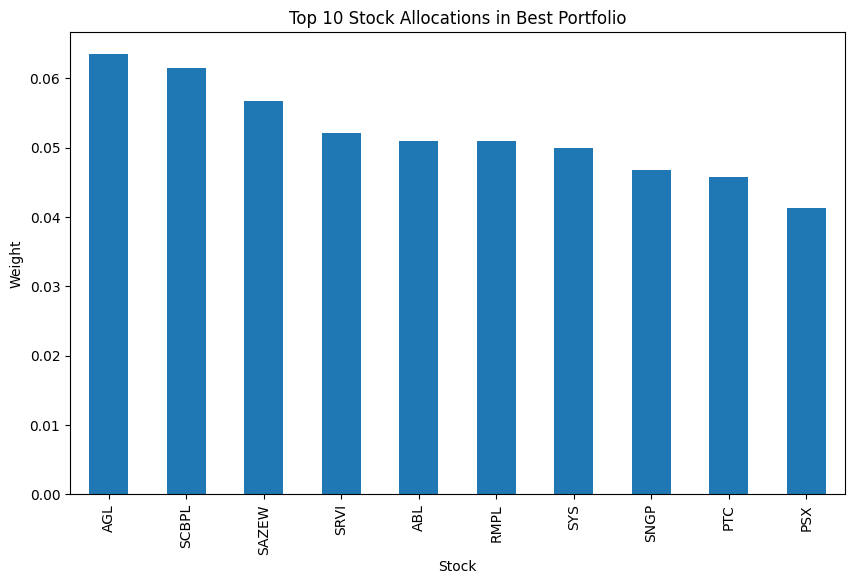

In [2586]:
# Display best portfolio weights and fitness
print("Best portfolio fitness score:", best_fitness)
best_weights = pd.Series(best_portfolio, index=returns_df.index)
top_stocks = best_weights.sort_values(ascending=False).head(10)
print("Top 10 stock allocations:")
print(top_stocks)

# Visualize allocation
plt.figure(figsize=(10,6))
top_stocks.plot(kind='bar')
plt.title("Top 10 Stock Allocations in Best Portfolio")
plt.ylabel("Weight")
plt.xlabel("Stock")
plt.show()

In [2587]:
# best_fitness_history = []
# best_portfolio = None
# best_fitness = -np.inf

# population = initialize_population(POP_SIZE, CHROMOSOME_LENGTH)
# for gen in range(NUM_GENERATIONS):
#     fitness_scores = evaluate_population(population, returns_matrix)
#     gen_best_idx = np.argmax(fitness_scores)
#     gen_best_fitness = fitness_scores[gen_best_idx]
#     best_fitness_history.append(gen_best_fitness)
#     if gen_best_fitness > best_fitness:
#         best_fitness = gen_best_fitness
#         best_portfolio = population[gen_best_idx].copy()
#     # # Check for convergence
#     # if gen > 5 and abs(best_fitness_history[-1] - best_fitness_history[-2]) < DELTA_THRESHOLD:
#     #     print(f"Converged at generation {gen}.")
#     #     break
#     # Selection
#     parents = tournament_selection(population, fitness_scores, POP_SIZE // 2)
#     # Crossover
#     offspring = generate_offspring(parents)
#     # Mutation
#     mutated_offspring = mutate_population(offspring.copy(), MUTATION_RATE)
#     # New population: combine parents and mutated offspring
#     population = np.vstack([parents, mutated_offspring])

# print("Genetic algorithm completed.")

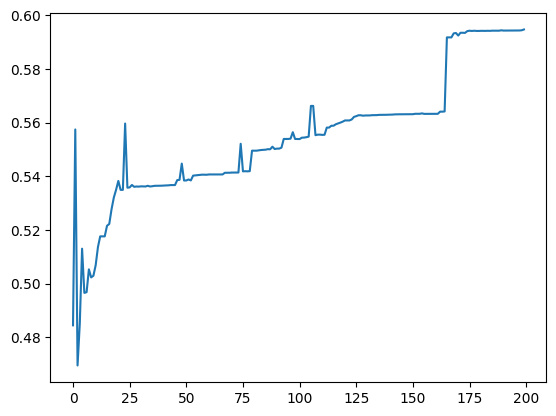

In [2588]:
plt.plot(best_fitness_history)

In [2589]:
print(best_fitness)

0.5947839507840273


In [2590]:
best_weights[best_weights < 0.005] = 0

In [2591]:
best_weights /= best_weights.sum()

In [2592]:
best_weights.sort_values(ascending=False).to_csv("portfolio_tournament_unsorted.csv")